<a href="https://colab.research.google.com/github/JieShenAI/kaggle/blob/main/jshen/torch/underfit-overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


In [1]:
!pip install jshen --upgrade

In [2]:
from j_torch.j_torch import * 

In [18]:
import torch
import math
from torch import nn

In [3]:
import numpy as np

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集生成样本。


In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
max_degree = 20
n_train, n_test = 100, 100
true_w = torch.zeros(max_degree)
true_w[0:4] = torch.Tensor([5, 1.2, -3.4, 5.6])

In [5]:
def shuffle(features):
    idx = torch.randperm(features.shape[0])
    return features[idx].view(features.size())

In [3]:
def generate_polydata(true_w, data_len):
    """
    类似泰勒公式
    https://github.com/JieShenAI/jshen/blob/main/img/ac1f22abfc4f6d71886f873bced8f4a.png
    :param true_w:
    :param max_degree: 一维变量的长度
    :param data_len: 生成的数据长度
    :return:
    """
    max_degree = len(true_w)
    features = torch.normal(0, 1, size=(data_len, 1))
    # 将数据shuffle
    features = shuffle(features)
    # 多项式
    poly_features = torch.pow(features, torch.arange(max_degree).reshape(1, -1))
    # 除以i的阶乘是为了避免数据过大
    for i in range(max_degree):
        poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
    # labels
    labels = torch.matmul(poly_features, true_w)
    # 加一个噪音
    labels += torch.normal(0, 0.01, size=labels.shape)
    return poly_features,labels

In [4]:
poly_features,labels = generate_polydata(true_w,n_train + n_test)

In [5]:
poly_features.shape,labels.shape

(torch.Size([200, 20]), torch.Size([200]))

In [6]:
true_w

tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

In [8]:
def shuffle(features):
    idx = torch.randperm(features.shape[0])
    return features[idx].view(features.size())

同样，存储在`poly_features`中的单项式由gamma函数重新缩放，
其中$\Gamma(n)=(n-1)!$。
从生成的数据集中[**查看一下前2个样本**]，
第一个值是与偏置相对应的常量特征。


In [ ]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [ ]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.2188],
         [0.8013]]),
 tensor([[1.0000e+00, 2.1884e-01, 2.3945e-02, 1.7467e-03, 9.5563e-05, 4.1826e-06,
          1.5255e-07, 4.7692e-09, 1.3046e-10, 3.1722e-12, 6.9420e-14, 1.3811e-15,
          2.5186e-17, 4.2398e-19, 6.6273e-21, 9.6688e-23, 1.3224e-24, 1.7024e-26,
          2.0697e-28, 2.3838e-30],
         [1.0000e+00, 8.0134e-01, 3.2107e-01, 8.5761e-02, 1.7181e-02, 2.7535e-03,
          3.6775e-04, 4.2099e-05, 4.2169e-06, 3.7546e-07, 3.0087e-08, 2.1918e-09,
          1.4636e-10, 9.0221e-12, 5.1641e-13, 2.7588e-14, 1.3817e-15, 6.5129e-17,
          2.8995e-18, 1.2229e-19]]),
 tensor([5.1750, 5.5118]))

### 对模型进行训练和测试

首先让我们[**实现一个函数来评估模型在给定数据集上的损失**]。


In [9]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    # 应该转成评估模式的
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [133]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）
    Defined in :numref:`sec_softmax_scratch`"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


In [10]:
def train_epoch(net, trainer, loss, data_load, epochs):
    """
    通过dataload训练epochs次
    :param net:
    :param trainer:
    :param loss:
    :param data_load:
    :param epochs:
    :return:
    """
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    for _ in range(epochs):
        for fea, lab in data_load:
            l = loss(net(fea), lab)
            trainer.zero_grad()
            l.mean().backward()
            trainer.step()
            # print('batch loss: {}'.format(l))

现在[**定义训练函数**]。


In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array(train_features, train_labels.reshape(-1,1),
                                batch_size,True)
    test_iter = load_array(test_features, test_labels.reshape(-1,1),
                               batch_size,False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch(net, trainer, loss,train_iter,  1)
        # 每20个epoch用训练的模型算一下test_loss
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data)

In [21]:
def load_array(features, label, batch_size, shuffle):
    """
    data,label -> iter
    测试集，没必要shuffle，所以这里没有给shuffle指定默认值
    """
    dataset = torch.utils.data.TensorDataset(features, label)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle)

### [**三阶多项式函数拟合(正常)**]

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。


In [8]:
poly_features[:10:]

tensor([[ 1.0000e+00,  3.7046e-01,  6.8619e-02,  8.4734e-03,  7.8476e-04,
          5.8144e-05,  3.5899e-06,  1.8999e-07,  8.7978e-09,  3.6213e-10,
          1.3415e-11,  4.5180e-13,  1.3948e-14,  3.9746e-16,  1.0517e-17,
          2.5975e-19,  6.0141e-21,  1.3106e-22,  2.6972e-24,  5.2590e-26],
        [ 1.0000e+00,  2.8762e+00,  4.1363e+00,  3.9656e+00,  2.8514e+00,
          1.6403e+00,  7.8629e-01,  3.2307e-01,  1.1615e-01,  3.7120e-02,
          1.0676e-02,  2.7916e-03,  6.6910e-04,  1.4804e-04,  3.0413e-05,
          5.8315e-06,  1.0483e-06,  1.7736e-07,  2.8340e-08,  4.2901e-09],
        [ 1.0000e+00, -1.6620e+00,  1.3812e+00, -7.6517e-01,  3.1793e-01,
         -1.0568e-01,  2.9274e-02, -6.9506e-03,  1.4440e-03, -2.6666e-04,
          4.4320e-05, -6.6965e-06,  9.2747e-07, -1.1858e-07,  1.4077e-08,
         -1.5597e-09,  1.6202e-10, -1.5840e-11,  1.4626e-12, -1.2794e-13],
        [ 1.0000e+00, -1.6688e+00,  1.3924e+00, -7.7450e-01,  3.2311e-01,
         -1.0784e-01,  2.9993e-02, 

weight: tensor([[ 5.0009,  1.2100, -3.3976,  5.5844]])


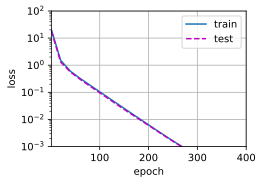

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
draw_train_loss_test_loss(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

In [144]:
true_w

tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

### [**线性函数拟合(欠拟合)**]

让我们再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。


weight: tensor([[3.8225, 3.9328]])


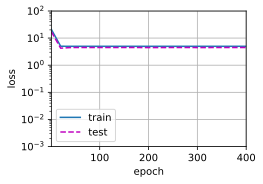

In [9]:
# 从多项式特征中选择前2个维度，即1和x
draw_train_loss_test_loss(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### [**高阶多项式函数拟合(过拟合)**]

现在，让我们尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。


weight: tensor([[ 4.9903e+00,  1.2886e+00, -3.2941e+00,  5.1627e+00, -4.5661e-01,
          1.3316e+00,  3.1594e-01,  1.0978e-02, -8.9156e-02,  1.5702e-01,
          1.3115e-01,  1.7902e-01,  1.5954e-03,  7.8868e-02, -1.3691e-01,
         -1.9781e-01,  1.0566e-01,  1.4532e-01,  1.8984e-01,  6.2317e-02]])


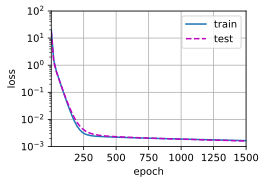

In [10]:
# 从多项式特征中选取所有维度
draw_train_loss_test_loss(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

在接下来的章节中，我们将继续讨论过拟合问题和处理这些问题的方法，例如权重衰减和dropout。

## 小结

* 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
* 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
* 验证集可以用于模型选择，但不能过于随意地使用它。
* 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。

## 练习

1. 你能准确地解出这个多项式回归问题吗？提示：使用线性代数。
1. 考虑多项式的模型选择：
    1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。你观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
    1. 在这种情况下绘制测试的损失图。
    1. 生成同样的图，作为数据量的函数。
1. 如果你不对多项式特征$x^i$进行标准化($1/i!$)，会发生什么事情？你能用其他方法解决这个问题吗？
1. 你能期待看到泛化误差为零吗？


[Discussions](https://discuss.d2l.ai/t/1806)
